# FashionMNIST analysis using Deep Belief Networks

In [ ]:
def _get_files_from_repo(files, repo):
  repository_url = f"https://raw.githubusercontent.com/flavio2018/{repo}/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
files = ["DBN.py", "RBM.py"]
_get_files_from_repo(files, "Deep-Belief-Network-pytorch")

In [ ]:
import math
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as functional
import torchvision as tv
from tqdm.notebook import tqdm
import scipy.cluster as cluster
import numpy as np
import sklearn.preprocessing
from sklearn import metrics
import itertools
from IPython.utils import io

from DBN import DBN

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
%%capture
train = tv.datasets.FashionMNIST('data/',
                                 train=True,
                                 download=True,
                                 transform=tv.transforms.Compose(
                                     [tv.transforms.ToTensor(),
                                      tv.transforms.Normalize(0.2862, 0.3530)]
                                     ))

test = tv.datasets.FashionMNIST('data/',
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                    [tv.transforms.ToTensor(),
                                     tv.transforms.Normalize(0.2862, 0.3530)]
                                    ))

In [ ]:
train.data = (train.data.type(torch.FloatTensor)/255).to(device)
test.data = (test.data.type(torch.FloatTensor)/255).to(device)
train.targets = train.targets.to(device)
test.targets = test.targets.to(device)

In [ ]:
labels = {
    0 : 'T-shirt/top',
    1	: 'Trouser',
    2	: 'Pullover',
    3	: 'Dress',
    4	: 'Coat',
    5	: 'Sandal',
    6	: 'Shirt',
    7	: 'Sneaker',
    8	: 'Bag',
    9	: 'Ankle boot'
}

def get_name(label):
  if(isinstance(label, torch.Tensor)):
    return labels[label.item()]
  return labels[label]

In [ ]:
def plot_samples(mnist_set, index, n):

  fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(6*n,6))

  for i in range(n):
    img = mnist_set.data[index+i]
    ax[i].imshow(img.to('cpu') , cmap = 'gray')
    label = mnist_set.targets[index+i]
    ax[i].set_title('Target label: %s, %s' % (format(label), get_name(label)))
    ax[i].set_xticks([])
    ax[i].set_yticks([])


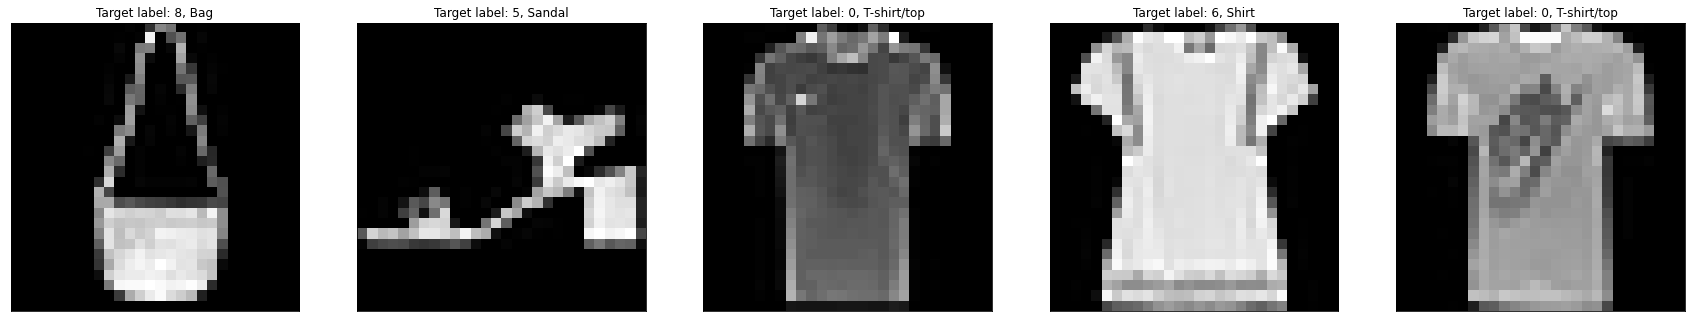

In [ ]:
plot_samples(train, 520, 5)

# Linear read-outs

In this section we perform linear read-outs at different levels of the model hierarchy. We also tune the hyperparameters that defines the DBN model.



In [ ]:
# Definition of the linear model used for the read-outs.

class LinearModel(torch.nn.Module):
  def __init__(self, layer_size, device):
    super().__init__()
    self.linear = torch.nn.Linear(in_features=layer_size, out_features=10, device=device)

  def forward(self, x):
    return self.linear(x)

In [ ]:
# The function returns an array containing the output of each neuron of the k-th layer.

def get_kth_layer(dbn, input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  # Perform the predictions, given the flattened input.
  hidden_repr, __ = dbn.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

In [ ]:
# The function returns an array containing the output of each neuron of the last layer of the network.

def get_last_hidden(dbn):
  hidden_layer = train.data
  for i in range(0, dbn.n_layers):
    hidden_layer = get_kth_layer(dbn, hidden_layer, i, device)
  return hidden_layer

In [ ]:
# The function trains the linear model, given the input (hidden_reprs) and
# the target output (the labels in training_set).

def train_linear(linear, hidden_reprs, train_targets, verbose=True):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1500

  for epoch in range(epochs):
    optimizer.zero_grad()
    # predictions contains the linear model's predicted values.
    predictions = linear(hidden_reprs).squeeze()
    # targets contains the actual labels of the training set.
    targets = train_targets.reshape(predictions.shape[0])
    # Compute the loss and update the weights.
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 300 == 0 and verbose:
      print("epoch : %s/%s, loss = %.4f" % (epoch + 1, epochs, loss))

  return

In [ ]:
# The function compute the accuracy of the model.
# The array predictions_test contains the probabilities of belonging to a class
# for each sample of the test set.

def compute_accuracy(predictions_test, targets):
  # Convert probabilities to the index of the predicted class
  predictions_indices = predictions_test.max(axis=1).indices
  # Sum the correctly classified samples and compute the accuracy
  accuracy = (predictions_indices == targets).sum() / len(targets)

  return accuracy.item()

In [ ]:
# The class wrap both the DBN model and the linear read-outs trained starting from the model.

class DBNreadouts():
  def __init__(self, dbn, readouts_list):
    self.readouts = readouts_list
    self.dbn = dbn

## Tuning of hyperparameters


To find the best initialization of the hyperparameters, we first require a dictionary of possible values for the architecture of the network (number of neurons, number of layers) and for other parameters, as the learning rate, the weight decay, the number of epochs and the batch size.

Then, a DBN for every combination of the values provided is trained, and the best model is chosen by training and computing the empirical risk of the linear readout associated to the last layer of the DBN.

In [ ]:
# This function, given a dictionary of hyperparameters, computes and returns
# the score on the training set (1 - training error) of the last readout of the DBN.

def score_dbn_train(params, train_data, train_targets, verbose = False):

  # Using the function get, we can set default parameters if they are not in the dict.
  hidden_units = params.get('hidden_units', [400, 500, 800])
  learning_rate = params.get('learning_rate', 0.1)
  weight_decay = params.get('weight_decay', 0.0001)
  num_epochs = params.get('num_epochs', 50)
  batch_size = params.get('batch_size', 125)

  if(verbose):
    print('Training DBN of parameters: hidden_units =', hidden_units,
        'lr =', learning_rate, 'weight_decay =', weight_decay,
        'num_epochs =', num_epochs, 'batch_size =', batch_size)

  # Initialize the DBN model.
  dbn = DBN(visible_units=28*28,
            hidden_units=hidden_units,
            learning_rate=learning_rate,
            k=1,
            learning_rate_decay=False,
            initial_momentum=0.5,
            final_momentum=0.9,
            weight_decay=weight_decay,
            xavier_init=False,
            increase_to_cd_k=False,
            use_gpu=True)

  # Capture the print output to reduce verbosity.
  with io.capture_output() as captured:

    # Train the dbn
    dbn.train_static(
        train_data,
        train_targets,
        num_epochs,
        batch_size
    )

  # Starting from the visible layer, we computer the output of each layer
  # using the training set as input.
  hidden_layer = get_kth_layer(dbn, train_data, 0, device)
  # At the end of the loop, the variable contains the output of the last layer.
  for i in range(1, len(hidden_units)):
    hidden_layer = get_kth_layer(dbn, hidden_layer, i, device)

  # Initialize and train the linear readout for the last layer.
  linear = LinearModel(dbn.rbm_layers[len(hidden_units)-1].W.shape[1], device)
  train_linear(linear, hidden_layer, train_targets, verbose=False)

  # Predict the probabilities using the last linear readout
  predictions_train = linear(hidden_layer)

  # Return the accuracy of the last layer and the DBN model
  return compute_accuracy(predictions_train, train_targets), dbn, linear

In [ ]:
# This function, given a dictionary of hyperparameters, computes and returns
# the score on the test set (1 - test error) of the last readout of the DBN.

def score_dbn_test(params, train_data, train_targets, test_data, test_targets):
  _, dbn, linear = score_dbn_train(params, train_data, train_targets)
  hidden_units = params.get('hidden_units', [400, 500, 800])

  # Starting from the visible layer, we computer the output of each layer
  # using the test set as input.
  hidden_layer_test = get_kth_layer(dbn, test_data, 0, device)

  # At the end of the loop, the variable contains the output of the last layer.
  for i in range(1, len(hidden_units)):
    hidden_layer_test = get_kth_layer(dbn, hidden_layer_test, i, device)

  predictions_test = linear(hidden_layer_test)
  # Return the accuracy of the last layer and the DBN model
  return compute_accuracy(predictions_test, test_targets)

In [ ]:
# The function, given a dictionary of possible values for the hyperparameter,
# computes the empirical risk for the dbn made using each combination of the dictionary.
# It returns the best model and the best set of parameters.

def find_best_params(params_dict):
  hyperp_list = []
  accuracies = []
  dbn_models = []
  # Create a dictionary for every possible combination of values for the hyperparameters
  for hp in itertools.product(*params_dict.values()):
    hp_dict={}
    i = 0
    for key in params_dict.keys():
      hp_dict[key] = hp[i]
      i += 1
    hyperp_list.append(hp_dict)

  # For every combination of values, a dbn is trained using those hyperparameters
  for hp_dict in hyperp_list:

    # Compute the training error for this set of hyperparameters
    accuracy, dbn, _ = score_dbn_train(hp_dict, train.data, train.targets, verbose=True)
    print('\tAccuracy:', accuracy)
    accuracies.append(accuracy)
    dbn_models.append(dbn)

  # Find the index of the model with best accuracy.
  max_acc_index = np.argmax(np.array([accuracies]))

  # Return the best model and the best set of parameters.
  return dbn_models[max_acc_index], hyperp_list[max_acc_index]

In [ ]:
params = {
    'hidden_units': [[400, 500, 800], [600, 800, 1000], [400, 500, 800, 1000]],
    'learning_rate': [0.1],
    'num_epochs' : [75],
    'batch_size' : [125]
}

In [ ]:
best_dbn, best_params = find_best_params(params)

Training DBN of parameters: hidden_units = [400, 500, 800] lr = 0.1 weight_decay = 0.0001 num_epochs = 75 batch_size = 125
	Accuracy: 0.84743332862854
Training DBN of parameters: hidden_units = [600, 800, 1000] lr = 0.1 weight_decay = 0.0001 num_epochs = 75 batch_size = 125
	Accuracy: 0.8501666784286499
Training DBN of parameters: hidden_units = [400, 500, 800, 1000] lr = 0.1 weight_decay = 0.0001 num_epochs = 75 batch_size = 125
	Accuracy: 0.8463500142097473


Once the best set of parameters is found, we train each linear readout for every layer of the network. To do it, we compute the output given by each layer of the DBN, and then for each layer we build the corresponding linear model to be trained.

In [ ]:

# The function creates and trains the linear readouts for each layer of the network.
# The type returned wraps the model and the linear readouts.

def train_readouts(dbn):
  linear_readouts = []
  hidden_layer = train.data

  # The readout for each layer of the network is created and trained, using the training_set
  for i in range(0, dbn.n_layers):
    hidden_layer = get_kth_layer(dbn, hidden_layer, i, device)
    linear = LinearModel(dbn.rbm_layers[i].W.shape[1], device)
    print('Training layer', i+1)
    train_linear(linear, hidden_layer, train.targets, verbose=True)
    linear_readouts.append(linear)

  return DBNreadouts(dbn, linear_readouts)

The class DBNreadout is used to wrap together both the DBN and the list of linear readouts.

In [ ]:
dbn_ro = train_readouts(best_dbn)

Training layer 1
epoch : 1/1500, loss = 2.2893
epoch : 301/1500, loss = 0.6033
epoch : 601/1500, loss = 0.5156
epoch : 901/1500, loss = 0.4754
epoch : 1201/1500, loss = 0.4510
Training layer 2
epoch : 1/1500, loss = 2.3474
epoch : 301/1500, loss = 0.5688
epoch : 601/1500, loss = 0.4949
epoch : 901/1500, loss = 0.4611
epoch : 1201/1500, loss = 0.4406
Training layer 3
epoch : 1/1500, loss = 2.3279
epoch : 301/1500, loss = 0.5758
epoch : 601/1500, loss = 0.4985
epoch : 901/1500, loss = 0.4638
epoch : 1201/1500, loss = 0.4429


For each linear readout of the model, we compute the generalization error, computing the accuracy on the test set.

In [ ]:
# Compute the test error for each model's readout

hidden_layer_test = test.data
for i in range(0, dbn_ro.dbn.n_layers):
  hidden_layer_test = get_kth_layer(dbn_ro.dbn, hidden_layer_test, i, device)
  linear = dbn_ro.readouts[i]
  predictions_test = linear(hidden_layer_test)
  print("Accuracy for layer %d: %.8f" % (i+1, compute_accuracy(predictions_test, test.targets)))

Accuracy for layer 1: 0.83769995
Accuracy for layer 2: 0.84169996
Accuracy for layer 3: 0.83889997


In this section, we found the best set of hyperparameter that minimizes the training error. Using the model with the best score, we built a linear read-out for each layer of the DBN. These models, trained using the hidden representation of the samples (the output of the considered layer) and the training set, can approximate the accuracy of each hidden layer. As expected, the deepest layer of the network presents the best classification score. That can suggest an increasing disentanglement made by the DBN as we procede to deeper layers of the network.

# Analysis of the internal representations

To develop some intuitions about how the model processes the given input, we now analyze its internal representations. Firstly, we discover the similarities that the model implicitly finds, exploiting its hierarchical clustering. Then, we are going to visualize the weights of each layer to understand how the neurons recognize the input's features.

## Exploit of the hierarchical clustering

To classify each sample, the network internally finds some similarities among  the possible classes, doing an implicit clustering. In this paragraph we try to understand how this hierarchical clustering works.

In [ ]:
# The function filters the labels by class and compute the mean.

def get_label_to_mean(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  ret = {}
  for label in range(10):
    ret[label] = hidden_representation_np[label==train.targets.cpu().numpy()].mean(axis=0)
  return ret


# The function builds the matrix needed to compute the clustering.

def get_hidden_reprs_matrix(hidden_representation):
  label_to_mean = get_label_to_mean(hidden_representation)
  ret = np.expand_dims(label_to_mean[0], axis=0)
  for label in range(1,10):
    ret = np.concatenate([ret, np.expand_dims(label_to_mean[label], axis=0)])
  return ret


# The function plots a dendrogram using a hierarchical clustering complete link.

def plot_dendrogram(mean_repr_matrix, title=''):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method='complete')
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)
  return

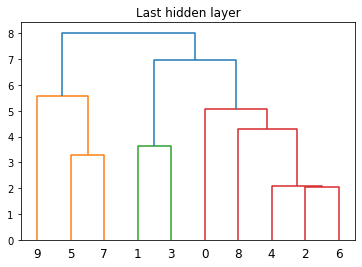

In [ ]:
plot_dendrogram(get_hidden_reprs_matrix(get_last_hidden(dbn_ro.dbn)), 'Last hidden layer')

 ## Visualization of the receptive fields


The visualization of the network's weights can be useful to understand how the model is searching for similiarities, and how the units are triggered by some parts of an image. A representative set of weights is plotted for each layer of the network. To do it, we also used a threshold on the learned weights to reduce the noise in the images, and a MinMaxScaler to compare different receptive fields in a proper way.

In [ ]:
# The function returns the weights of the DBN for a chosen layer.

def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()


# The function apply a threshold to a set of weight, to reduce the plot's noise.

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)


# The function scales the weights respect their minimum and maximum values, to
# normalize the visualization of the weights.

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

In [ ]:
# The function receives a plot and inserts in the proper subplots the weights'
# visualization for a given layer of the network

def plot_layer_receptive_fields(weights, n_rows_cols, title, fig, ax, layer_index):

  # Plot the weights in the proper subplots
  for x in range(n_rows_cols**2):
    row = x % n_rows_cols
    col = x // n_rows_cols + layer_index * (n_rows_cols+1)

    ax[row, col].imshow(weights[x,:].reshape((28,28)), cmap=plt.cm.gray)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

  # Set the title for the layer
  ax[0, (n_rows_cols//2)+layer_index*(n_rows_cols+1)].set_title(title)

  # Plot a blank column to separate each layer
  for x in range(n_rows_cols):
    ax[x, (n_rows_cols+1)*(layer_index+1) - 1].set_visible(False)
  return


# The function plot some of the DBN's weights

def plot_weights(dbn, weights_per_side):
  n_rows_cols = weights_per_side

  fig, ax = plt.subplots(nrows=n_rows_cols, ncols=(n_rows_cols+1)*dbn.n_layers,
                      figsize=(10*dbn.n_layers,10))

  # Compute the weights for each layer
  for i in range(dbn.n_layers):
    weights_layers_list=[]

    for j in range(i+1):
      weights_layer = get_weights(dbn, layer=j)
      weights_layers_list.append(weights_layer)

    weights_product = apply_threshold(weights_layers_list[0], 0.1)
    for j in range(1, len(weights_layers_list)):
      weights_product = weights_product @ apply_threshold(weights_layers_list[j], 0.1)

    if(len(weights_layers_list)>1):
      weights_product = apply_threshold(weights_product, 0.1)
    weights_product = apply_min_max_scaler(weights_product)

    title = 'Weights layer ' + str(i)
    plot_layer_receptive_fields(weights_product.T, n_rows_cols, title, fig, ax, i)

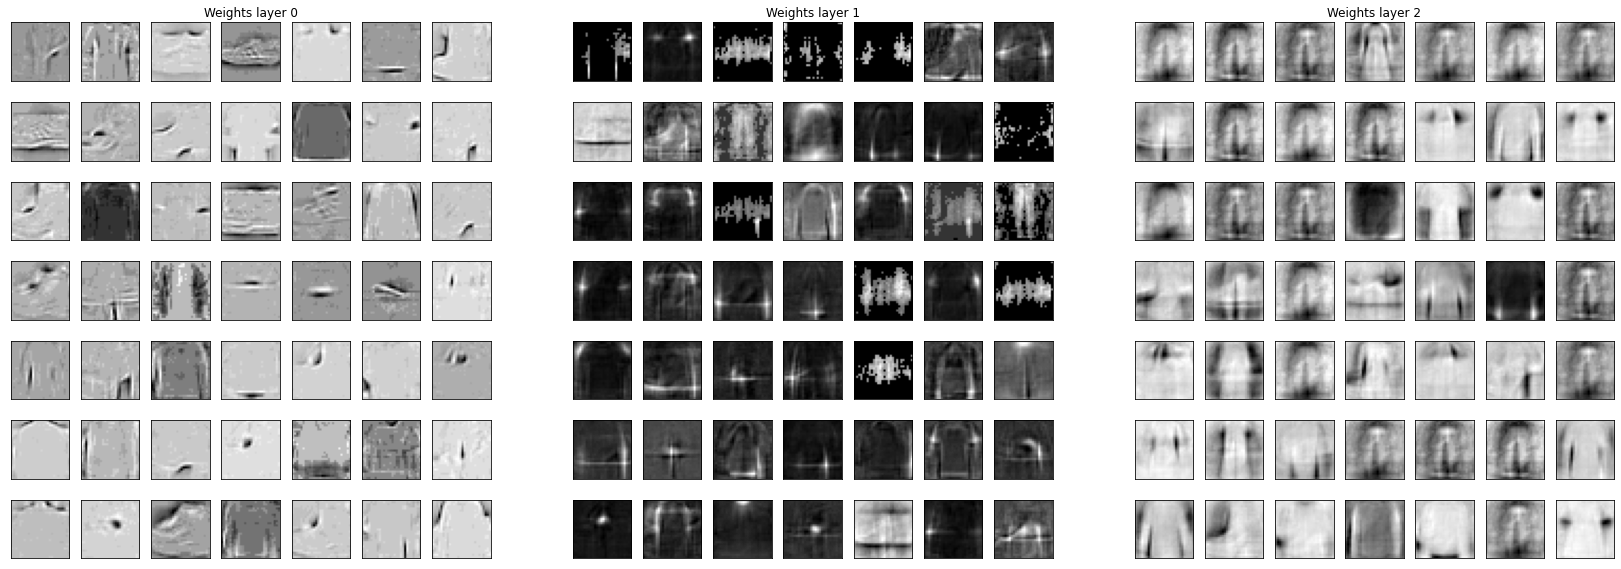

In [ ]:
plot_weights(dbn_ro.dbn, 7)

In this section we tried to analyze the internal representation of the data. Finding the hierarchical clustering, we could get a hint of how the model classifies the data, and understand which similiarities among different classes the model can grasp. For example, the model used here found similarities among the classes "pullover", "shirt" and "coat", and between the classes "sandal" and "sneaker".

The weights' visualization can suggest instead which parts of the images a neuron can analyze. For example, we can notice that some weights recognize shapes like dresses, others like shoes or trousers. As espected, the weights of deeper layers result noisier and less defined, therefore the specialization of each weight is less visible.



# Confusion matrices and psychometric curves

To investigate the kind of errors made by the model, we now plot the confusion matrices and we analyze the strenght of the model when an amount of noise is added to the test samples.

## Confusion matrices

The confusion matrices are important to explore how the model performs classification errors. In one table, each row represents the instances in an actual class while each column represents the instances in a predicted class.
The matrix makes it easy to see if the system is confusing two classes, commonly mislabeling one as another.

In [ ]:
# The function plots in a given subplot the confusion matrix for a layer of a DBN.

def print_conf_matrix(dbn, true_labels, pred_labels, index, fig, ax):
  # Compute the confusion matrix given the true and the predicted labels
  confusion_matrix = metrics.confusion_matrix(true_labels.cpu().detach().numpy(), pred_labels.cpu().detach().numpy())
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
  disp.plot(ax=ax[index])
  if(index != dbn.n_layers-1):
    disp.im_.colorbar.remove()
  title = 'Confusion matrix layer ' + str(index)
  disp.ax_.set_title(title)

In [ ]:
# The function plots all the confusion matrices for the layers of a DBN.

def confusion_matrices(dbn_readouts):
  hidden_layer_test = test.data
  fig, ax = plt.subplots(nrows=1,ncols=dbn_readouts.dbn.n_layers, figsize=(6*dbn_readouts.dbn.n_layers, 6))
  # For every layer of the DBN plot the confusion matrix
  for i in range(0, dbn_readouts.dbn.n_layers):
    hidden_layer_test = get_kth_layer(dbn_readouts.dbn, hidden_layer_test, i, device)

    # Compute the predicted labels using the matching linear read-out
    linear = dbn_readouts.readouts[i]
    predictions_test = linear(hidden_layer_test)

    # Transforms probabilities into predicted labels
    labels_pred_test = predictions_test.max(axis=1).indices
    print_conf_matrix(dbn_readouts.dbn, test.targets, labels_pred_test, i, fig, ax)

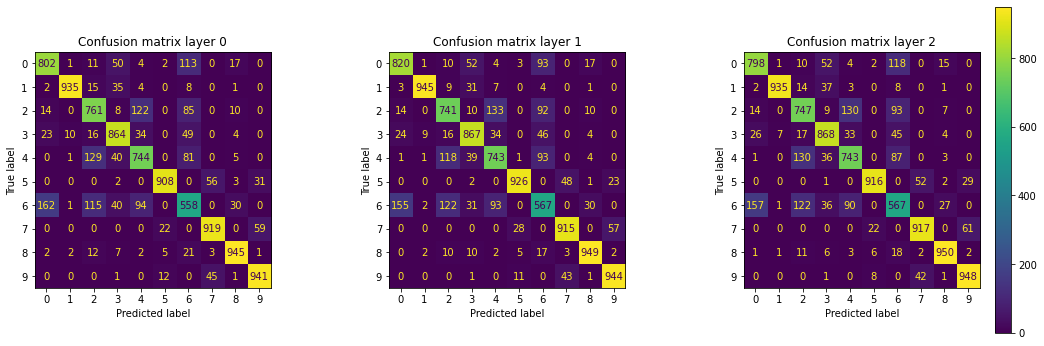

In [ ]:
confusion_matrices(dbn_ro)

## Psychometric curves

The psychometric curves, created by adding an increasing amount of noise to the test data, are plotted in order to find the robustness of the model to classify new samples affected by gaussian noise.

In [ ]:
# The function adds to the data a tensor of gaussian noise, proportional to the noise level.

def inject_noise(data, noise_level):
  random_gaussian_tensor = torch.randn(data.shape, device = device)*noise_level
  return data + random_gaussian_tensor

In [ ]:
# The function plots n noisy samples from a set, starting from index

def plot_noisy_samples(mnist_set, index, n, noise_level):

  fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(9,5*n))

  for i in range(n):
    img = mnist_set.data[index+i]
    noisy_img = inject_noise(img, noise_level)
    ax[i, 0].imshow(img.to('cpu'), cmap = 'gray')
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 0].set_title('Normal sample')
    ax[i, 1].imshow(noisy_img.to('cpu'), cmap = 'gray')
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    ax[i, 1].set_title('Noisy sample')

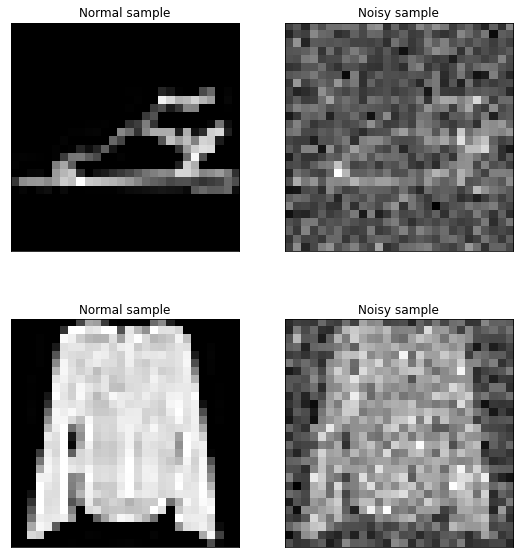

In [ ]:
plot_noisy_samples(train, index=300, n=2, noise_level=0.3)

In [ ]:
# The function get the accuracy of a DBN model when a noise level is injected in
# the test data.

def get_accuracy_values_at_noise_level(noise_level, dbn_readouts):
  ret = []
  # Create the noisy test data.
  hidden_layer_noisy = inject_noise(test.data, noise_level)

  # Compute the accuracy for all the layers of the model.
  for i in range(dbn_readouts.dbn.n_layers):
    hidden_layer_noisy = get_kth_layer(dbn_readouts.dbn, hidden_layer_noisy, i, device)
    # Use the linear read-out to predict the probability of belonging to a class for every test sample.
    linear = dbn_readouts.readouts[i]
    predictions_noisy = linear(hidden_layer_noisy)
    # Compute the accuracy and return the list of accuracies for each layer
    accuracy = compute_accuracy(predictions_noisy, test.targets)
    ret.append(accuracy)

  return ret

In [ ]:
# The function plots the psychometric curves for each layer of the network.

def plot_noise_robustness_curves(noise_levels, dbn_readouts):
  fig, ax = plt.subplots()

  # Initialize the matrix of accuracies
  acc_matrix = np.zeros(dbn_readouts.dbn.n_layers)

  # For each noise level, get the list of accuracies for every layer
  # and insert that as a row in the matrix
  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level, dbn_readouts)
    acc_matrix = np.vstack((acc_matrix, acc))

  # Remove the first row of zeros
  acc_matrix = acc_matrix[1:,:]

  # A column of the matrix corresponds to the accuracies for one layer changing
  # the noise level
  for i in range(acc_matrix.shape[1]):
    layer_acc = acc_matrix[:,i]
    ax.plot(range(layer_acc.shape[0]), layer_acc)

  # Plotting title and legend
  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  legend = []
  for i in range(dbn_readouts.dbn.n_layers):
    legend.append('Layer ' + str(i))
  plt.legend(legend)

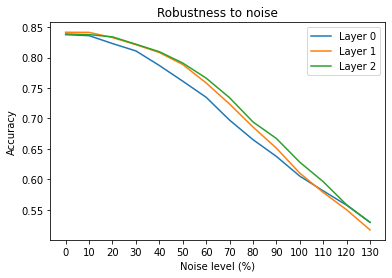

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels, dbn_ro)

The confusion matrices plotted in this section suggest that the layers of the network are usually fairly accurate, as the diagonal of each matrix (in which there are the correctly classified samples) presents a large number of samples. Moreover, from those we can understand some weaknesses of the model, like the classification of the class "shirt", quite commonly classified as "T-shirt/top" or "pullover".

The model seems quite robust in the classification of samples affected by gaussian noise, if the noise level remains below the 50%. However, as expected, inspecting the accuracy for a fixed noise level, it increases as we go to deeper layers of the network.

# Adversarial attacks and few-shots learning

In this section we explore the capability of the model when an adversarial attack is performed and when the training set cardinality is reduced.


## Response for adversarial attacks

To perform an attack to the model, we modify the input to make the model less accurate in the classification, creating new adversarial samples.

We create an adversarial sample modifying the input during the training going in the same direction as the gradient of a sample.

The modified sample will be presented as:
$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [ ]:
# The function perturbate a sample as explained above

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

In [ ]:
# The class uses the linear read-out of a layer to perform the prediction

class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn = dbn
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [ ]:
# The function plots n adversarial samples from a set, starting from index, using our pre-trained dbn.

def plot_perturbed_samples(mnist_set, index, n, dbn_ro, epsilon):

  dbn_readout = DBNWithReadOut(dbn_ro.dbn, dbn_ro.readouts, readout_level=dbn_ro.dbn.n_layers-1)
  fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(9,5*n))

  for i in range(n):
    img = mnist_set.data[index+i].reshape(1, 784)
    img.requires_grad_()
    true_label = mnist_set.targets[index+1].unsqueeze(0)
    model_outputs = dbn_readout(img)
    predicted_label = torch.argmax(model_outputs)

    ax[i, 0].imshow(img.reshape(28,28).cpu().detach().numpy())
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 0].set_title('Normal sample')

    loss_value = torch.nn.functional.cross_entropy(model_outputs, true_label)
    dbn_readout.zero_grad()
    loss_value.backward()
    img_grad = img.grad.data

    perturbed_img = fgsm_attack(img, epsilon, img_grad)

    ax[i, 1].imshow(perturbed_img.reshape(28,28).cpu().detach().numpy())
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    ax[i, 1].set_title('Perturbed sample')

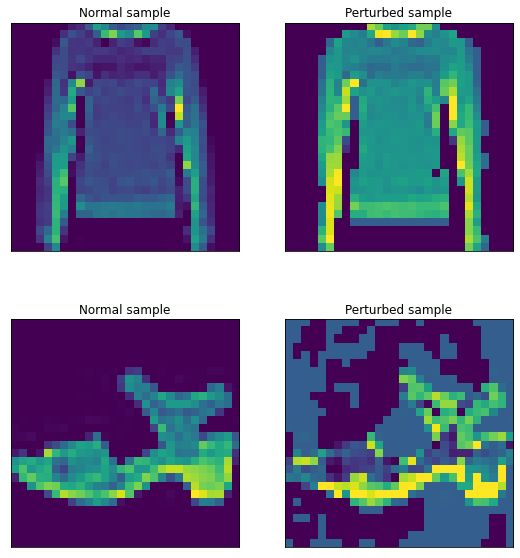

In [ ]:
plot_perturbed_samples(train, index=400, n=2, dbn_ro=dbn_ro, epsilon=0.3)

In [ ]:
# The function performs the attack for a value of epsilon.

def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
  correct = 0
  print_reconstruction = num_steps > 0

  for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    data = data.reshape(-1, 784)
    data.requires_grad = True

    output = model.forward(data)

    init_pred = torch.argmax(output)

    if (print_reconstruction and verbose):
      print("\nHere's the original sample:\n")
      plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
      plt.show()

    loss = functional.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    # Collect the gradient of the input data
    data_grad = data.grad.data
    perturbed_data = fgsm_attack(data, epsilon, data_grad)

    if (print_reconstruction and verbose):
      print("\nHere's a perturbed sample:\n")
      plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
      plt.show()

    # If requested, reconstruct the input iterating forward-backward dynamics
    if num_steps > 0:
      for __ in range(0, num_steps):
        perturbed_data, __ = model.dbn.reconstruct(perturbed_data)
      if (print_reconstruction and verbose):
        print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
        plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
        plt.show()
        print_reconstruction = False

    # Re-classify the perturbed image
    output = model(perturbed_data)

    # Check for success and get the index of the max element in the output
    final_pred = output.max(1, keepdim=True)[1]
    final_pred = output.argmax(-1)
    correct += (final_pred == target).sum()

  # Calculate final accuracy for this epsilon
  final_acc = correct/float(len(test_loader.sampler))
  print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

  return final_acc.item()

In [ ]:
# Dataloader to perform the attack on the test set
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=20, shuffle=True)

In [ ]:
# Compute the accuracy for the model changing the value of epsilon

def test_epsilon_values_effect(model, epsilon_values, n_steps):
  accuracies = []
  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
def adv_attack(dbn_readout):
  accuracy_adv = []
  eps_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

  # Perform the attack using as predictor each read-out of the model.
  # For each layer, both the normal prediction and the reconstruction are used and plotted
  for i in range(dbn_ro.dbn.n_layers):
    dbn_readout = DBNWithReadOut(dbn_ro.dbn, dbn_ro.readouts, readout_level=i)
    with io.capture_output() as captured:
      accuracy = test_epsilon_values_effect(dbn_readout,eps_values, n_steps=0)
    accuracy_adv.append(accuracy)
    with io.capture_output() as captured:
      accuracy = test_epsilon_values_effect(dbn_readout,eps_values, n_steps=1)
    accuracy_adv.append(accuracy)

  # Plot the curves
  fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)
  ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
  ax.set_ylabel("Accuracy")
  ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})

  legend = []

  for i in range(0, len(accuracy_adv), 2):
    ax.plot(eps_values, accuracy_adv[i])
    ax.plot(eps_values, accuracy_adv[i+1])
    legend.append("DBN layer "+str(int(i/2)))
    legend.append("DBN top-down layer "+str(int(i/2)))

  ax.legend(legend)
  plt.show()

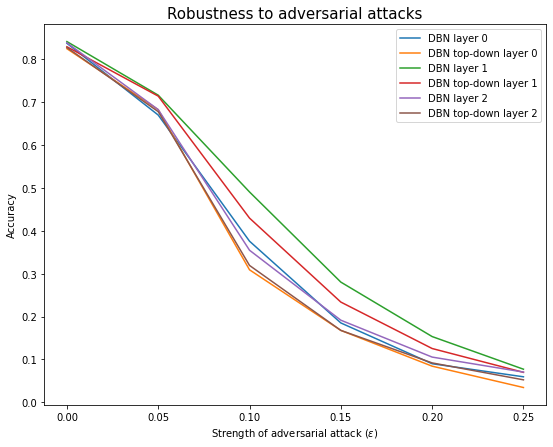

In [ ]:
adv_attack(dbn_ro)

## Few-shots learning

In this last part we explore how the accuracy can change as the training set cardinality changes.

In [ ]:
# The function compute the accuracy of the last layer's read-out using as training
# set a set of samples of variable size, starting from the batch size given as input
# and using multiples of it as size, performing up to n_iteration iterations.

def fs_learning(batch_size, n_iteration):
  accuracies_few = []
  batch_values = []

  # The upper bound assure that we cannot use more than the available samples in the dataset
  upper_bound = min(len(train.data), batch_size*(n_iteration+1))

  # Use as training set size the multiples of batch_size up to the upper bound
  for batch in range(batch_size, upper_bound, batch_size):
    batch_values.append(batch)
    train_loader = torch.utils.data.DataLoader(
        tv.datasets.FashionMNIST('data/', train=True, download=False,
                              transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
                              batch_size=batch)
    test_loader = torch.utils.data.DataLoader(
        tv.datasets.FashionMNIST('data/', train=False, download=False,
                              transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
                              batch_size=batch)

    for test_data, test_targets in test_loader:
      test_data = test_data.to(device)
      test_targets = test_targets.to(device)
      # Compute the accuracy for one batch of the training set
      for train_data, train_targets in train_loader:
        train_data = train_data.to(device)
        train_targets = train_targets.to(device)
        acc = score_dbn_test(best_params, train_data, train_targets, test_data, test_targets)
        accuracies_few.append(acc)
        break

      break

  return accuracies_few, batch_values

In [ ]:
def plot_fs(accuracies, batch_sizes):
  fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)
  ax.set_xlabel("Number of samples in the training set")
  ax.set_ylabel("Accuracy on the test set")
  ax.set_title("Test score", {'fontsize': 15})

  ax.plot(batch_sizes, accuracies)

  i=0
  for x,y in zip(batch_sizes,accuracies):
    if(i%5==0 or i==0):
      label = "{:.2f}".format(y)
      plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
    i+=1

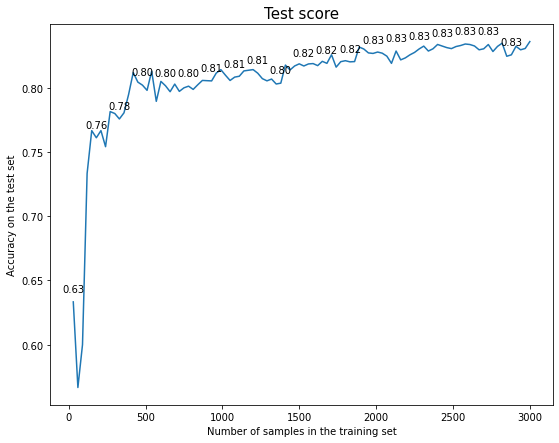

In [ ]:
# Compute the accuracies and plot the found curves
accuracies, batch_values = fs_learning(30, 100)
plot_fs(accuracies, batch_values)

The model seems not so good in the classification of perturbed samples, as the accuracy rapidly decreases when performing an adversarial attack. Conversely to the expected results, the reconstruction of a sample reduces the score of the model, and the last layer of the network has a worst robustness than the middle one.

Training the network with a small amount of samples in respect to the size of the entire training set considerably reduces the accuracy of the model. However, as expected the accuracy improves as the training set dimension increases, reaching a score value of 0.837% using only 1/20 of the dataset's training set.    